# Analysis of Ad-Hoc Communications Network
The user can supply the overall size of desired coverage footprint andthen we will determine the following:

- Given an overall desired coverage footprint and a sequence of n communications
towers, what is the resulting resolved coverage?
- What is the total area of coverage relative to the desired total coverage area of the
original footprint? That is, are there any gaps in coverage?
- On average, how many communications towers are required before full coverage is
obtained?

Inputs w and h represent width and height of the desired region map to analyze, respectively 

In [220]:
import numpy as np
import matplotlib.pyplot as plt

def create_map(w,h):
    """
    Create a blank region area based on user input w and h, and plot the empty map
    :param w: width of the desired area 
    :param h: height of desired area
    :return: numpy area of 0's which will represent the blank map area
    """

    
    blank = np.zeros((h, w))

    return blank

# Adding a Tower
When we add a tower, we will first select a random point, and then select a random coverage area such that the coverage is in-bounds. Tow_placed will represent each tower in the numpy array. We will add the new area, overlap and all to the previous values/coverage. After that, we can seperate everything that is not open area and ignore it temporarily for the sake of finding the maximum coverage area.

In [289]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches

rectangle_data = []

def add_tower(w,h, data):
    """
    Adds tower, and returns so that each step can be shown in a visualization
    :param n: number of towers remaining
    :param w: width of region map
    :param h: height of region map
    :param data: the current map with current amount of towers
    :return: updated map with one tower added
    """
    import random
    import itertools
    assert isinstance(w,int)
    assert isinstance(h,int)
    assert w>0 and h>0
    
    # determines tower random width and height of rectangle (minimum 1)
    tow_width = random.randint(1, w+1)
    tow_height = random.randint(1, h+1)

    # determines which corner to start at, such that the tower is completely within the map
    s_cornerw = random.randint(0, (w+1)-tow_width)
    s_cornerh = random.randint(0, (h+1)-tow_height)

    # update numpy array if there are still towers left to be placed
    # tow_placed is the count of how many towers we've placed so far
    global tow_placed
    global rectangle_data 
    tow_placed = tow_placed + 1

    data1 = np.copy(data)
    
    # add the new tower in, with overlapping areas and no trimming yet
    data[s_cornerh:(s_cornerh+tow_height), s_cornerw:(s_cornerw+tow_width)] += tow_placed
    
    # call max_rectangle to get the new tower coverage area
    rectangle = max_rectangle(data, tow_placed)
    
    # data[data > tow_placed] = 1
    # data[data == tow_placed] = 0
    # exit_case will be returned if the whole map is full, to exit a loop in main
    exit_case = 1
    
    # this seemingly complex operation simply flips the starting point, so that its going from top to bottom like before
    if (rectangle != 'Area already covered'):
        s_cornerw1 = rectangle[0][1]
        s_cornerh1 = rectangle[0][0] - rectangle[2] + 1
        tow_height1 = rectangle[2]
        tow_width1 = rectangle[1]
        flipped_rect = (s_cornerh1, s_cornerw1), tow_width1, tow_height1
        rectangle_data.append(flipped_rect)
        data1[s_cornerh1:(s_cornerh1+tow_height1), s_cornerw1:(s_cornerw1+tow_width1)] += tow_placed
    else:
        while(rectangle=='Area already covered'):
            if(np.count_nonzero(data == 0) == 0):
                return data, exit_case
            data[s_cornerh:(s_cornerh+tow_height), s_cornerw:(s_cornerw+tow_width)] -= tow_placed  # undo addition
            tow_placed -= 1
            return add_tower(w, h, data)
    return data1

# Finding the maximum rectangle
Finding the largest area rectangle is a decepitively difficult problem that requires brute force, or a semi-complex algorithm. I found the largest rectangle coverage area by changing the original coverage matrix into a histogram of the values in columns above it. Each of these rows can represent a "histogram" of bar plots, and whichever histogram has the largest rectangle, will give us the corner, length and width of the maximum area rectangle

# Histogram Example <br>
Input   							
[0 1 1 0]<br>						
[1 1 1 1]<br>
[1 1 1 1]<br>
[1 1 0 0]<br>

Histogram <br>
[0 1 1 0] area = 2 <br>
[1 2 2 1] area = 4 <br>
[2 3 3 2] area = 8 * this is where the maximum rectangle is!<br>
[3 4 0 0] area = 6 <br>

-This method is more efficient than using brute force, it saves more memory, and the Time Complexity is only O(R*X).

In [290]:
def max_rectangle(data, tow_placed):
    """
    Updates the numpy array with the new rectangle 
    :param data: non trimmed map, numpy array
    :param tow_placed: number of the tower being placed, int
    :return: 
    """
    
    R = len(data) 
    C = len(data[0])
    
    # A will be transformed to represent a "histogram" of the coverage area
    A = np.copy(data)

    # copies the map to A. overlap areas are greater than tow_placed, 
    # array values that are == to tow_placed represent new coverage areas which will be
    #  represented by "1"; remove all values but the new coverage areas and make these "0"
    fully_enclosed = 0
    for each_row in range(0, R):
        for each_column in range(0, C):
            if A[each_row][each_column] == tow_placed:
                A[each_row][each_column] = 1
            else:
                A[each_row][each_column] = 0
                
    # if area is already fully covered, return an error string
    if np.count_nonzero(A) == 0:
        return "Area already covered"
    0
    # turns A into a "histogram" of coverage per column for tower number tow_placed
    # The idea is to update each column of a given row with corresponding column of previous row
    for each_row in range(1, R):
        for each_column in range(0, C):
            if A[each_row][each_column] == 1:
                A[each_row][each_column] += A[each_row-1][each_column]
                
    # call maxHistArea, and find which rectangle under the "histogram" has the most area.
    # make the area of the first row the current max_area
    max_area = sum(A[0])
    maxarea_row = 0
    for each_row in range (0,R):
        if maxHistArea(A[each_row]) > max_area:
            max_area = maxHistArea(A[each_row])
            maxarea_row = each_row

            # maxarea_row stores the row number where histogram row max_area was found in. 
            # this row number is where the the bottom most row in our max rectangle as well
    
    # Using the maxarea_row number from our "histogram" matrix, and the max area value, we can find the length, width, 
    # and coordinates of the resulting rectangle by using the structure of a histogram

    rec_height=1
    rec_width=1
    for i in A[maxarea_row]:
        if (sum(check(A[maxarea_row], i)) * i) == (max_area):
            rec_height = i
            rec_width = sum(check(A[maxarea_row], i))

    # coordinates of starting corner of rectangle
    start_corner = np.where((A[maxarea_row]) >= rec_height)
    start_corner_col = start_corner[0][0]
    start_corner_row = maxarea_row 
    
    return [[start_corner_row, start_corner_col], rec_width, int(rec_height)]

In [291]:
def maxHistArea(heights):
    """"
    Given a list of "histogram" heights we will find the maximum possible rectangle area
    :param heights: list of "histogram" heights
    :return int: area of the biggest rectangle in that "histogram"
    """
    increasing, area, i = [], 0, 0
    while i <= len(heights):
        if not increasing or (i < len(heights) and heights[i] > heights[increasing[-1]]):
            increasing.append(i)
            i += 1
        else:
            last = increasing.pop()
            if not increasing:
                area = max(area, heights[last] * i)
            else:
                area = max(area, heights[last] * (i - increasing[-1] - 1 ))
    return area


# The Check List<br>
This list is used as a semi-efficient way of not only double checking the maximum area, but also finding the bottom left most coordinate of the maximum area rectangle. If we first find the row of the histogram with the max Area, we can then make one of these lists for every value in that row. The product of that value * sum(repective list) will give us a possible area rectangle, and if we do it for every value in the row, we can find every single possible rectangle.

In [292]:
def check(list1, val):
    """
    Given a list, create a list where entries are 1 if value is greater than or equal to val, and 0 otherwise
    :param list1: list entered 
    :param val: val to compare to
    :return: binary list
    """
    # traverse in the list
    list2 = []
    for x in list1:
 
        # compare with all the values
        # with val
        if x >= val:
            list2.append(1)
        else:
            list2.append(0)
            
    return list2

In [312]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines 
import matplotlib.patches as patches


def plot_tower(rectangle_data,w,h):
    '''
    :param s_cornerw: corner x coordinate 
    :param s_cornerh: corner y coordinate
    :param tow_width: rectangle width
    :param tow_height: rectangle height
    :return: 
    '''
    
    current_rec=[]

    
    figure = plt.figure()
    ax = figure.add_subplot(111, aspect='equal')
    
    for i in rectangle_data:
        print i
        current_rec.append(patches.Rectangle(i[0], i[1], i[2], color='g'))
    for p in current_rec:
        ax.add_patch(p)
    plt.ylim((0,h))
    plt.xlim((0,w))

((6, 14), 1, 6)
((0, 5), 10, 4)
((4, 1), 10, 11)
((6, 12), 2, 9)
((4, 11), 1, 11)
((0, 2), 3, 4)
((4, 12), 2, 2)


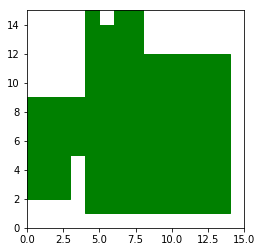

In [313]:
rectangle_data
plot_tower(rectangle_data, 15, 15)

# Main 
Sets global variable tow_placed and global list rectangle_data, and adds towers to the map n times. Returns and prints the final updated numpy array

In [295]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines 
import matplotlib.patches as patches

def main(n, w, h):
    """
    :param n: number of towers to be placed, is decremented every time a tower is placed
    :param w: width of map
    :param h: height of map
    :return: 
    """
    assert isinstance(n, int)
    assert isinstance(w, int)
    assert isinstance(h, int)
    assert w>0
    assert h>0
    assert n>0

    # every rectangle stored in the form [[corner_w, corner_h], width, height]
    global rectangle_data 
    rectangle_data = []
    global tow_placed 
    tow_placed = 0
    
    # creates blank region map
    region_map = create_map(w, h)
    print (region_map)
    print 
    # adds one tower
    x = add_tower(w, h, region_map)
    
    result_coverage = None
    # loops and adds until we have placed n towers, and returns the final array
    for n_count in range(1,n):
        x = add_tower(w, h, x)
        if n_count == n-1:
            result_coverage = np.copy(x)
    print result_coverage
    return result_coverage



# Visulatization Example
Visualize every tower being placed in the map

# Example 1
Given an overall desired coverage footprint and a sequence of n communications
towers, what is the resulting resolved coverage?
With n = 7 towers, w = 15, h = 15


In [314]:
#example for n=7, w=15, h=15
example = main(7, 15, 15)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[[0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0.]
 [0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0.]
 [0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 5. 5. 5. 5. 5. 5. 5. 5. 0. 0. 0. 0. 0.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 

# Example 2
What is the total area of coverage relative to the desired total coverage area of the
original footprint? That is, are there any gaps in coverage?


In [315]:
rectangle_data

[((3, 1), 12, 1),
 ((0, 2), 12, 3),
 ((5, 0), 12, 3),
 ((8, 3), 9, 7),
 ((4, 2), 8, 1),
 ((6, 12), 2, 4),
 ((10, 12), 1, 5)]

In [227]:
def relative_coverage(desired, data, w, h):
    """
    :param n: number of towers to be placed, is decremented every time a tower is placed
    :param w: width of map
    :param h: height of map
    :param data: final updated map
    :return: % of coverage, and percent of coverage relative to what was wanted
    """
    non_zeros = np.count_nonzero(data)
    total_points = (w*h)
    coverage = non_zeros
    overall_cov = (float(coverage)/float(total_points))*100
    per_relative = (float(coverage)/float(desired))*100
    print ('The total coverage area from this simulation is:', coverage)
    print ('The percent of overall coverage is: ' + '{:.2f}'.format(overall_cov)+'%')
    print ('The % coverage relative to the desired total area is: ' + '{:.2f}'.format(per_relative)+'%')

In [229]:
# relative_coverage(desired_coverage, data, w, h) 
# Example desired coverage = 150, w=15, h=15
print example
relative_coverage(150, example, 15, 15)

[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [0. 6. 6. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [0. 6. 6. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [0. 6. 6. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [0. 6. 6. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 7. 7. 7. 7. 4. 4. 4. 4. 5. 5. 5. 5. 5.]
 [0. 0. 7. 7. 7. 7. 4. 4. 4. 4. 0. 0. 0. 0. 0.]
 [0. 0. 7. 7. 7. 7. 4. 4. 4. 4. 0. 0. 0. 0. 0.]
 [0. 0. 7. 7. 7. 7. 4. 4. 4. 4. 0. 0. 0. 0. 0.]]
('The total coverage area from this simulation is:', 198)
The percent of overall coverage is: 88.00%
The % coverage relative to the desired total area is: 132.00%


# Example 3
On average, how many communications towers are required before full coverage is
obtained?<br>
Using the Law of Large Numbers, we can assume 200 simulations will give us an average amount of towers required for full coverage in a WxH area.



In [234]:
def num_towers_full(w, h):
    """
    Given a width and height, how many towers does it take to fill up the map?
    :param w: width of area
    :param h: height of area
    :return: number of towers used
    """
    region = create_map(w,h)
    x = add_tower(w,h, region)
    count = 1
    while(np.count_nonzero(x) < w*h):
        x = add_tower(w,h,x)
        count += 1
    return count
def average_towers_full(w, h):
    """
    See how many towers it takes to fill up the map, 300 different times
    :param w: width of area
    :param h: height of area
    :return: average towers it takes to fill up a map
    """
    listof_numTowers = []
    for i in range(0,300):
        z = num_towers_full(w, h)
        listof_numTowers.append(float(z))
    
    return (sum(listof_numTowers)/300.0)


In [235]:
# print(average_towers_full(w,h))
# prints the avg number of towers needed, as a float, to fill up the map
# Example with width =10 and height =10
print(average_towers_full(10,10))

12.61


TypeError: unsupported operand type(s) for -: 'list' and 'list'

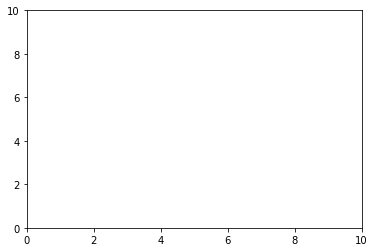

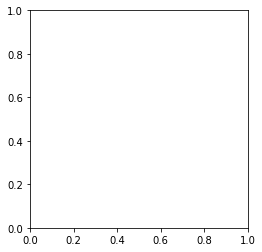

In [240]:
plot_tower([rectangle_data],10,10)

# Limitations
- Cannot choose between 2 equally sized new coverage areas
- Cannot maximize coverage for tower since they are randomly placed
- Random size and placement becomes a problem when very little spaces are left available, run time can increase if the last 0 is not covered


# Assumptions
- Law of Large Numbers: 300 simulations is enough for an accurate average
	- An example of the Law of Large number can be seen here [Graph of Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers#/media/File:Lawoflargenumbers.svg)